In [1]:
from collections import defaultdict
import pickle
import pandas as pd
import numpy as np
import OSU

# pull out top 10k resistant and bottom 10k resistant sequences across both backbones, between DMSO and 12.5 uM

# Load JTE607 data from both backbones individually
# Filter based off of DMSO reads per variant

# L3 loading and counting reads, filter away variants with < 50 reads in DMSO
L3_shared_5p = "GCGAATTGGAGCTCTTCTTTTTGTCACTTGAAAAACATGTAAAAATAATGTACTAGGAGACACTTTCAATAAA"
L3_shared_3p = "TCGGGTGATTATTTACCCCCCACCCTTGCCGTCTGCGAGAATTCGAT"
parsed_L3_cleaved_output_dir = "/JTE-607/Analysis/parsed_L3_input_RNA_clusterPASRandom_bbmerge_xloose/parsed_L3_cleaved_RNA_multimapping_mincov1_preload_bbmerge_xloose_H1shortN4indel/collapsed/"
polyA_L3_DMSO_cleaved_pickle = parsed_L3_cleaved_output_dir + "L3_DMSO_polya_pos_dict.pickle"
polyA_L3_12p5uM_cleaved_pickle = parsed_L3_cleaved_output_dir + "L3_12p5uM_polya_pos_dict.pickle"

L3_polyA_pos_pickle_dict = {"L3_DMSO": polyA_L3_DMSO_cleaved_pickle,\
              "L3_12p5uM": polyA_L3_12p5uM_cleaved_pickle}

L3_PAS_read_counts = defaultdict(int)
polya_pos_dict = pickle.load(open(polyA_L3_DMSO_cleaved_pickle, "rb"))
data_name = "L3_DMSO"
for curr_PAS, curr_polya_pos_count_dict in polya_pos_dict.items():
    curr_total_reads = sum(curr_polya_pos_count_dict.values())
    curr_PAS = curr_PAS.strip()
    if curr_total_reads >= 50:
        L3_PAS_read_counts[curr_PAS] += curr_total_reads

# SVLst loading and counting reads, filter away variants with < 50 reads in DMSO
SVLst_shared_5p = "GCGAATTGGAGCTCATGCTTTATTTGTGAAATTTGTGATGCTATTGCTTTATTTGTAACCATTATAAGCTGCAATAAA"
SVLst_shared_3p = "ATTTTATGTTTCAGGTTCAGGGGGAGGTGTGGGAGGTTTTTTAAAGCAAGTAGAATTCGAT"
parsed_SVLst_cleaved_output_dir = "/JTE-607/Analysis/parsed_SVLst_input_RNA_clusterPASRandom_bbmerge_xloose/parsed_SVLst_cleaved_RNA_multimapping_mincov1_preload_bbmerge_xloose_H1shortN4indel/collapsed/"
polyA_SVLst_DMSO_cleaved_pickle = parsed_SVLst_cleaved_output_dir + "SVLst_DMSO_polya_pos_dict.pickle"
polyA_SVLst_12p5uM_cleaved_pickle = parsed_SVLst_cleaved_output_dir + "SVLst_12p5uM_polya_pos_dict.pickle"

SVLst_polyA_pos_pickle_dict = {"SVLst_DMSO": polyA_SVLst_DMSO_cleaved_pickle,\
              "SVLst_12p5uM": polyA_SVLst_12p5uM_cleaved_pickle}

SVLst_PAS_read_counts = defaultdict(int)
polya_pos_dict = pickle.load(open(polyA_SVLst_DMSO_cleaved_pickle, "rb"))
data_name = "SVLst_DMSO"
for curr_PAS, curr_polya_pos_count_dict in polya_pos_dict.items():
    curr_total_reads = sum(curr_polya_pos_count_dict.values())
    curr_PAS = curr_PAS.strip()
    if curr_total_reads >= 50:
        SVLst_PAS_read_counts[curr_PAS] += curr_total_reads

# combine L3 and SVLst, calculate percentages within each dataset
L3_PAS_percents_dict = {"L3_DMSO": None,\
              "L3_12p5uM": None}
SVLst_PAS_percents_dict = {"SVLst_DMSO": None,\
              "SVLst_12p5uM": None}

all_PAS = set()
for data_name, pickle_name in L3_polyA_pos_pickle_dict.items():
    polya_pos_dict = pickle.load(open(pickle_name, "rb"))
    PAS_read_counts = defaultdict(int)
    for curr_PAS, curr_polya_pos_count_dict in polya_pos_dict.items():
        if curr_PAS in L3_PAS_read_counts:
            curr_total_reads = sum(curr_polya_pos_count_dict.values())
            curr_PAS = L3_shared_5p + curr_PAS + L3_shared_3p
            PAS_read_counts[curr_PAS] += curr_total_reads
            all_PAS.add(curr_PAS)
    total_reads = float(sum(PAS_read_counts.values()))  # float for division later
    print("%s total_reads = " % (data_name), total_reads)
    percentage_dict = {curr_PAS:(curr_read_count/total_reads) for curr_PAS, curr_read_count in PAS_read_counts.items()}
    df = pd.DataFrame(list(percentage_dict.items()),columns = ['PAS', data_name.split("_")[1] + '_percent'])
    L3_PAS_percents_dict[data_name] = df

for data_name, pickle_name in SVLst_polyA_pos_pickle_dict.items():
    polya_pos_dict = pickle.load(open(pickle_name, "rb"))
    PAS_read_counts = defaultdict(int)
    for curr_PAS, curr_polya_pos_count_dict in polya_pos_dict.items():
        if curr_PAS in SVLst_PAS_read_counts:
            curr_total_reads = sum(curr_polya_pos_count_dict.values())
            curr_PAS = SVLst_shared_5p + curr_PAS + SVLst_shared_3p
            PAS_read_counts[curr_PAS] += curr_total_reads
            all_PAS.add(curr_PAS)
    total_reads = float(sum(PAS_read_counts.values()))  # float for division later
    print("%s total_reads = " % (data_name), total_reads)
    percentage_dict = {curr_PAS:(curr_read_count/total_reads) for curr_PAS, curr_read_count in PAS_read_counts.items()}
    df = pd.DataFrame(list(percentage_dict.items()),columns = ['PAS', data_name.split("_")[1] + '_percent'])
    SVLst_PAS_percents_dict[data_name] = df

print(len(all_PAS))

merged_PAS_percentage_L3 = None
for data_name, curr_df in L3_PAS_percents_dict.items():
    if merged_PAS_percentage_L3 is None:
        merged_PAS_percentage_L3 = curr_df
    else:
        merged_PAS_percentage_L3 = merged_PAS_percentage_L3.merge(curr_df, how='outer', on="PAS")
merged_PAS_percentage_L3 = merged_PAS_percentage_L3.fillna(0)
print(merged_PAS_percentage_L3.shape)
print("Unsorted merged_PAS_percentage_L3: ", merged_PAS_percentage_L3)
merged_PAS_percentage_L3 = merged_PAS_percentage_L3.set_index("PAS")
merged_PAS_percentage_L3.reset_index(level=0, inplace=True)

merged_PAS_percentage_SVLst = None
for data_name, curr_df in SVLst_PAS_percents_dict.items():
    if merged_PAS_percentage_SVLst is None:
        merged_PAS_percentage_SVLst = curr_df
    else:
        merged_PAS_percentage_SVLst = merged_PAS_percentage_SVLst.merge(curr_df, how='outer', on="PAS")
merged_PAS_percentage_SVLst = merged_PAS_percentage_SVLst.fillna(0)
print(merged_PAS_percentage_SVLst.shape)
print("Unsorted merged_PAS_percentage_SVLst: ", merged_PAS_percentage_SVLst)
merged_PAS_percentage_SVLst = merged_PAS_percentage_SVLst.set_index("PAS")
merged_PAS_percentage_SVLst.reset_index(level=0, inplace=True)

merged_PAS_percentage = pd.concat([merged_PAS_percentage_L3, merged_PAS_percentage_SVLst])
print("Unsorted merged_PAS_percentage: ", merged_PAS_percentage)

# sort merged datasets based on DMSO percentages
merged_PAS_percentage = merged_PAS_percentage.sort_values(by=["DMSO_percent"], ascending=False)
print("Sorted merged_PAS_percentage: ", merged_PAS_percentage)

# Normalize based on variant
PAS_percentage_normalized = merged_PAS_percentage.drop("PAS", 1)
PAS_percentage_normalized = PAS_percentage_normalized.div(PAS_percentage_normalized.sum(axis=1), axis=0)
PAS_percentage_normalized["PAS"] = merged_PAS_percentage["PAS"]
print("PAS_percentage_normalized: ", PAS_percentage_normalized)

# Sorting based on 12.5 uM and write out top 10000 "resistant" and "sensitive"
descending_PAS_percentage = PAS_percentage_normalized.sort_values(by=["12p5uM_percent"], ascending=False)
print("Descending 12p5uM_percent: ", descending_PAS_percentage)

# Take top 10000 resistant variants
resistant_10k_variants = descending_PAS_percentage.head(10000)
print("resistant_10k_variants: ", resistant_10k_variants)

# Take top 10000 sensitive variants
sensitive_10k_variants = descending_PAS_percentage.tail(10000)
print("sensitive_10k_variants: ", sensitive_10k_variants)

output_dir = OSU.create_directory("/JTE-607/Analysis/combined_backbones_mincov1_H1shortN4indel/")

resistant_10k_variants.to_csv(output_dir + "top_10k_resistant_mincov50_allCutSites.txt", sep="\t")
sensitive_10k_variants.to_csv(output_dir + "top_10k_sensitive_mincov50_allCutSites.txt", sep="\t")


L3_DMSO total_reads =  12533775.0
L3_12p5uM total_reads =  6192004.0
SVLst_DMSO total_reads =  7688631.0
SVLst_12p5uM total_reads =  4188442.0
261316
(158298, 3)
Unsorted merged_PAS_percentage_L3:                                                        PAS  DMSO_percent  \
0       GCGAATTGGAGCTCTTCTTTTTGTCACTTGAAAAACATGTAAAAAT...      0.000006   
1       GCGAATTGGAGCTCTTCTTTTTGTCACTTGAAAAACATGTAAAAAT...      0.000008   
2       GCGAATTGGAGCTCTTCTTTTTGTCACTTGAAAAACATGTAAAAAT...      0.000007   
3       GCGAATTGGAGCTCTTCTTTTTGTCACTTGAAAAACATGTAAAAAT...      0.000004   
4       GCGAATTGGAGCTCTTCTTTTTGTCACTTGAAAAACATGTAAAAAT...      0.000010   
...                                                   ...           ...   
158293  GCGAATTGGAGCTCTTCTTTTTGTCACTTGAAAAACATGTAAAAAT...      0.000004   
158294  GCGAATTGGAGCTCTTCTTTTTGTCACTTGAAAAACATGTAAAAAT...      0.000004   
158295  GCGAATTGGAGCTCTTCTTTTTGTCACTTGAAAAACATGTAAAAAT...      0.000005   
158296  GCGAATTGGAGCTCTTCTTTTTGTCACTTGAAAAACATGTAAAA

In [ ]:
# Normalize L3 data based on variant
L3_PAS_percentage_normalized = merged_PAS_percentage_L3.drop("PAS", 1)
L3_PAS_percentage_normalized = L3_PAS_percentage_normalized.div(L3_PAS_percentage_normalized.sum(axis=1), axis=0)
L3_PAS_percentage_normalized["PAS"] = merged_PAS_percentage_L3["PAS"]
print("L3_PAS_percentage_normalized: ", L3_PAS_percentage_normalized)

# Sort descending 12.5 uM percentage, aka sorted on resistance
L3_descending_PAS_percentage = L3_PAS_percentage_normalized.sort_values(by=["12p5uM_percent"], ascending=False)
print(L3_descending_PAS_percentage)

# Take top 10000 resistant variants
resistant_10k_variants = L3_descending_PAS_percentage.head(10000)
print(resistant_10k_variants)

# Take top 10000 sensitive variants
sensitive_10k_variants = L3_descending_PAS_percentage.tail(10000)
print(sensitive_10k_variants)

In [45]:
import SU
import OSU
import NAU
reload(SU)
import os

# Look through L3 backbone for DG correlation with cleavage resistance

"""
Run RNAstructure-Fold and efn2 for MFE DG
"""
def calc_DG_sequence_list(sequence_list, output_dir):
    DG_list = []
    for sequence in sequence_list:
        seqfile = NAU.make_seq(sequence, output_dir+"temp.seq")
        ctfile = output_dir+"temp.ct"
        SU.runRNAstructure_fold(seqfile, ctfile)
        dbnfile = output_dir+"temp.dbn"
        efn2file = output_dir+"temp.efn2"
        SU.runRNAstructure_efn2(ctfile, efn2file, simple=True)
        DG = SU.get_free_energy_efn2(efn2file)[0]
        DG_list.append(DG)
    OSU.remove_files([seqfile, ctfile, efn2file])
    return DG_list


def DG_from_ct_sequence_list(sequence_list, output_dir):
    DG_list = []
    for sequence in sequence_list:
        ctfile = output_dir + sequence + ".ct"
        efn2file = output_dir + sequence + ".efn2"
        if not os.path.exists(efn2file):
            SU.runRNAstructure_efn2(ctfile, efn2file, simple=True)
        DG = SU.get_free_energy_efn2(efn2file)[0]
        DG_list.append(DG)
    #OSU.remove_file(efn2file)
    return DG_list


RNAstructure_output_dir = OSU.create_directory("/JTE-607/Analysis/combined_backbones_mincov1_H1shortN4indel/L3_Fold_results/")

# TODO: figure out why notebooks are not affected by ~/.bash_profile
print(os.environ)
os.environ['DATAPATH'] = "/home/ec2-user/src/RNAstructure/data_tables"
os.environ['PATH'] += ":/home/ec2-user/src/RNAstructure/exe"

resistant_10k_variants_variable_seqs = list(resistant_10k_variants["PAS"])
sensitive_10k_variants_variable_seqs = list(sensitive_10k_variants["PAS"])

L3_resistant_10k_DG = DG_from_ct_sequence_list(resistant_10k_variants_variable_seqs, RNAstructure_output_dir)
L3_sensitive_10k_DG = DG_from_ct_sequence_list(sensitive_10k_variants_variable_seqs, RNAstructure_output_dir)

print("L3_resistant_10k_DG:\n", L3_resistant_10k_DG)
print("L3_sensitive_10k_DG:\n", L3_sensitive_10k_DG)


environ({'LANG': 'en_US.UTF-8', 'PATH': '/home/ec2-user/anaconda3/condabin:/home/ec2-user/anaconda3/bin:/usr/libexec/gcc/x86_64-redhat-linux/7:/usr/local/cuda/bin:/usr/local/bin:/opt/aws/bin:/usr/local/mpi/bin:/usr/local/cuda/bin:/usr/local/bin:/opt/aws/bin:/home/ec2-user/.dl_binaries/bin:/usr/local/mpi/bin:/opt/aws/neuron/bin:/usr/libexec/gcc/x86_64-redhat-linux/7:/usr/local/cuda/bin:/usr/local/bin:/opt/aws/bin:/usr/local/mpi/bin:/opt/amazon/openmpi/bin/:/opt/amazon/efa/bin/:/usr/local/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/home/ec2-user/.local/bin:/home/ec2-user/bin:/home/ec2-user/src/RNAstructure/exe', 'HOME': '/home/ec2-user', 'LOGNAME': 'ec2-user', 'USER': 'ec2-user', 'SHELL': '/bin/bash', 'CONDA_ROOT': '/home/ec2-user/anaconda3', 'JPY_PARENT_PID': '3460', 'TERM': 'xterm-color', 'CLICOLOR': '1', 'PAGER': 'cat', 'GIT_PAGER': 'cat', 'MPLBACKEND': 'module://ipykernel.pylab.backend_inline', 'KMP_DUPLICATE_LIB_OK': 'True', 'KMP_INIT_AT_FORK': 'FALSE', 'DATAPATH': '/home/ec2-user/src/R

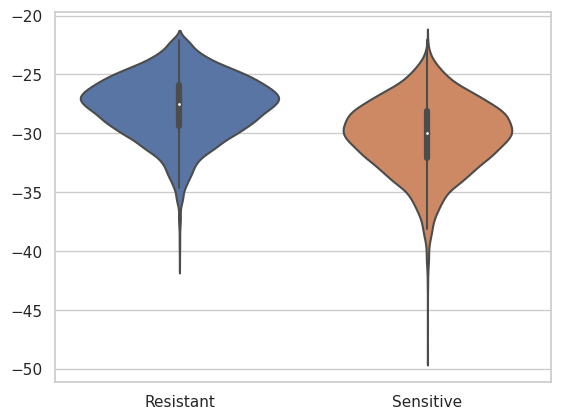

L3 resistant average DG =  -27.728300000000036
L3 sensitive average DG =  -30.22422999999998


In [46]:
import seaborn as sns

sns.set_theme(style="whitegrid")
ax = sns.violinplot(x=["Resistant"]*10000 + ["Sensitive"]*10000, y=L3_resistant_10k_DG+L3_sensitive_10k_DG)
plt.show()
plt.savefig(output_dir + "L3_resistant_sensitive_significant_10k_variants_DG.pdf")

print("L3 resistant average DG = ", sum(L3_resistant_10k_DG) / len(L3_resistant_10k_DG))
print("L3 sensitive average DG = ", sum(L3_sensitive_10k_DG) / len(L3_sensitive_10k_DG))

In [47]:
from scipy import stats

stats.ttest_ind(L3_resistant_10k_DG, L3_sensitive_10k_DG, equal_var=False)

Ttest_indResult(statistic=62.06532413845619, pvalue=0.0)

In [ ]:
# Normalize SVLst data based on variant
SVLst_PAS_percentage_normalized = merged_PAS_percentage_SVLst.drop("PAS", 1)
SVLst_PAS_percentage_normalized = SVLst_PAS_percentage_normalized.div(SVLst_PAS_percentage_normalized.sum(axis=1), axis=0)
SVLst_PAS_percentage_normalized["PAS"] = merged_PAS_percentage_SVLst["PAS"]
print("SVLst_PAS_percentage_normalized: ", SVLst_PAS_percentage_normalized)

# Sort descending 12.5 uM percentage, aka sorted on resistance
SVLst_descending_PAS_percentage = SVLst_PAS_percentage_normalized.sort_values(by=["12p5uM_percent"], ascending=False)
print(SVLst_descending_PAS_percentage)

# Take top 10000 resistant variants
resistant_10k_variants = SVLst_descending_PAS_percentage.head(10000)
print(resistant_10k_variants)

# Take top 10000 sensitive variants
sensitive_10k_variants = SVLst_descending_PAS_percentage.tail(10000)
print(sensitive_10k_variants)

In [5]:
import SU
import OSU
import NAU
import os

# Look through SVLst backbone for DG correlation with cleavage resistance

"""
Run RNAstructure-Fold and efn2 for MFE DG
"""
def calc_DG_sequence_list(sequence_list, output_dir):
    DG_list = []
    for sequence in sequence_list:
        seqfile = NAU.make_seq(sequence, output_dir+"temp.seq")
        ctfile = output_dir+"temp.ct"
        SU.runRNAstructure_fold(seqfile, ctfile)
        dbnfile = output_dir+"temp.dbn"
        efn2file = output_dir+"temp.efn2"
        SU.runRNAstructure_efn2(ctfile, efn2file, simple=True)
        DG = SU.get_free_energy_efn2(efn2file)[0]
        DG_list.append(DG)
    OSU.remove_files([seqfile, ctfile, efn2file])
    return DG_list


def DG_from_ct_sequence_list(sequence_list, output_dir):
    DG_list = []
    for sequence in sequence_list:
        ctfile = output_dir + sequence + ".ct"
        efn2file = output_dir + sequence + ".efn2"
        if not os.path.exists(efn2file):
            SU.runRNAstructure_efn2(ctfile, efn2file, simple=True)
        DG = SU.get_free_energy_efn2(efn2file)[0]
        DG_list.append(DG)
    #OSU.remove_file(efn2file)
    return DG_list


RNAstructure_output_dir = OSU.create_directory("/JTE-607/Analysis/combined_backbones_mincov1_H1shortN4indel/SVLst_Fold_results/")

# TODO: figure out why notebooks are not affected by ~/.bash_profile
print(os.environ)
os.environ['DATAPATH'] = "/home/ec2-user/src/RNAstructure/data_tables"
os.environ['PATH'] += ":/home/ec2-user/src/RNAstructure/exe"

resistant_10k_variants_variable_seqs = list(resistant_10k_variants["PAS"])
sensitive_10k_variants_variable_seqs = list(sensitive_10k_variants["PAS"])

SVLst_resistant_10k_DG = DG_from_ct_sequence_list(resistant_10k_variants_variable_seqs, RNAstructure_output_dir)
SVLst_sensitive_10k_DG = DG_from_ct_sequence_list(sensitive_10k_variants_variable_seqs, RNAstructure_output_dir)

print("SVLst_resistant_10k_DG:\n", SVLst_resistant_10k_DG)
print("SVLst_sensitive_10k_DG:\n", SVLst_sensitive_10k_DG)


environ({'LANG': 'en_US.UTF-8', 'PATH': '/usr/local/cuda-10.0/bin:/home/ec2-user/anaconda3/envs/python3/bin:/home/ec2-user/anaconda3/condabin:/home/ec2-user/src/RNAstructure/exe:/opt/amazon/openmpi/bin:/opt/amazon/efa/bin:/home/ec2-user/anaconda3/condabin:/home/ec2-user/.dl_binaries/bin:/usr/local/cuda/bin:/opt/aws/neuron/bin:/usr/libexec/gcc/x86_64-redhat-linux/7:/opt/aws/bin:/home/ec2-user/anaconda3/condabin:/home/ec2-user/anaconda3/bin:/usr/libexec/gcc/x86_64-redhat-linux/7:/usr/local/cuda/bin:/usr/local/bin:/opt/aws/bin:/usr/local/mpi/bin:/usr/local/cuda/bin:/usr/local/bin:/opt/aws/bin:/home/ec2-user/.dl_binaries/bin:/usr/local/mpi/bin:/opt/aws/neuron/bin:/usr/libexec/gcc/x86_64-redhat-linux/7:/usr/local/cuda/bin:/usr/local/bin:/opt/aws/bin:/usr/local/mpi/bin:/opt/amazon/openmpi/bin:/opt/amazon/efa/bin:/usr/local/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/home/ec2-user/.local/bin:/home/ec2-user/bin:/home/ec2-user/.local/bin:/home/ec2-user/bin', 'HOME': '/home/ec2-user', 'LOGNAME': 'ec

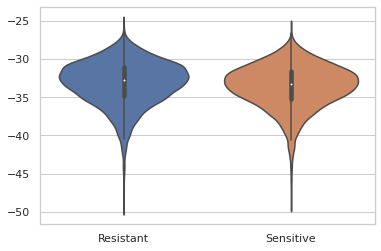

SVLst resistant average DG =  -33.157230000000034
SVLst sensitive average DG =  -33.58954999999994


<Figure size 432x288 with 0 Axes>

In [6]:
import seaborn as sns

sns.set_theme(style="whitegrid")
ax = sns.violinplot(x=["Resistant"]*10000 + ["Sensitive"]*10000, y=SVLst_resistant_10k_DG+SVLst_sensitive_10k_DG)
plt.show()
plt.savefig(output_dir + "SVLst_resistant_sensitive_10k_variants_DG.pdf")

print("SVLst resistant average DG = ", sum(SVLst_resistant_10k_DG) / len(SVLst_resistant_10k_DG))
print("SVLst sensitive average DG = ", sum(SVLst_sensitive_10k_DG) / len(SVLst_sensitive_10k_DG))

In [7]:
from scipy import stats

stats.ttest_ind(SVLst_resistant_10k_DG, SVLst_sensitive_10k_DG, equal_var=False)

Ttest_indResult(statistic=10.674571879713161, pvalue=1.578325308572078e-26)